From the dataset's description: 

"The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

The CIFAR-100 dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)."

We will be using the CIFAR-100 dataset.

Dataset source: http://www.cs.toronto.edu/~kriz/cifar.html

As requested, we will also cite Alex Krizhevsky's paper, Learning Multiple Layers of Features from Tiny Images (April 8, 2009) http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

## TODO: Business Case

## Preparation

In [9]:
import numpy as np

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

First, let's load the dataset. The meta file contains the actual titles

In [10]:
train = unpickle("cifar-100-python/train")
validation = unpickle("cifar-100-python/test")
meta = unpickle("cifar-100-python/meta")

X_train = train[b"data"]
X_validation = validation[b"data"]

y_train = train[b"fine_labels"]
y_validation = validation[b"fine_labels"]

label_names = meta[b"fine_label_names"]

### Preprocessing (10)

Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).   

The classes included in the dataset are shown below. To prepare our dataset, we decided to one hot encode the classes and normalize the pixel values from 0-255 to -1 to 1. We will be using the Classes column, but the Superclass column may come in useful for analyzing performance on the subclasses. 


| Superclass	|  Classes  |
| ----------- | --------- |
| aquatic mammals |	beaver, dolphin, otter, seal, whale |
| fish |	aquarium fish, flatfish, ray, shark, trout |
| flowers |	orchids, poppies, roses, sunflowers, tulips |
| food containers |	bottles, bowls, cans, cups, plates |
| fruit and vegetables |	apples, mushrooms, oranges, pears, sweet peppers |
| household electrical devices | clock, computer keyboard, lamp, telephone, television |
| household furniture |	bed, chair, couch, table, wardrobe |
| insects |	bee, beetle, butterfly, caterpillar, cockroach |
| large carnivores |	bear, leopard, lion, tiger, wolf |
| large man-made outdoor things |	bridge, castle, house, road, skyscraper |
| large natural outdoor scenes |	cloud, forest, mountain, plain, sea |
| large omnivores and herbivores |	camel, cattle, chimpanzee, elephant, kangaroo |
| medium-sized mammals |	fox, porcupine, possum, raccoon, skunk |
| non-insect invertebrates |	crab, lobster, snail, spider, worm |
| people |	baby, boy, girl, man, woman |
| reptiles |	crocodile, dinosaur, lizard, snake, turtle |
| small mammals |	hamster, mouse, rabbit, shrew, squirrel |
| trees	| maple, oak, palm, pine, willow |
| vehicles 1 |	bicycle, bus, motorcycle, pickup truck, train |
| vehicles 2 |	lawn-mower, rocket, streetcar, tank, tractor |

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__

'2.0.8'

In [12]:
from sklearn.preprocessing import normalize

y_train_labels = [label_names[index] for index in y_train]
y_validation_labels = [label_names[index] for index in y_validation]
NUM_CLASSES = 100

y_train_ohe = y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_validation_ohe = keras.utils.to_categorical(y_validation, NUM_CLASSES)

In [13]:
X_train_scaled = normalize(X_train)
X_validation_scaled = normalize(X_validation)

D:\anaconda\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


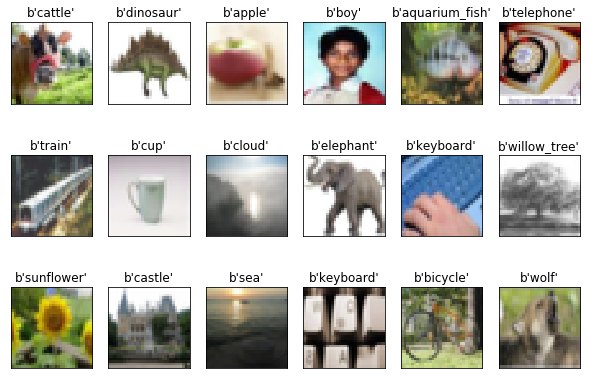

In [14]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        
        # this line is to get the images to display properly. 
        # Due to the way the data is stored, more has to be done on the data than the basic stuff in the example notebooks.
        # rot90(image, 1 rotation, (1,0)) does a 90 degree clockwise rotation
        # images[i].reshape((3,h,w)).T splits the image into its proper channels from its flattened form
        plt.imshow(np.rot90(images[i].reshape((3, h, w)).T, 1, (1,0)))
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train_labels, 32, 32) # defaults to showing a 3 by 6 subset

### Evaluation Metric

We will be using accuracy to measure the performance of the algorithm. We don't particularly care about any class over another, so false classifications don't weigh more or less either way. What we might run into is the existence of too many classes to effectively train the models on. For example, in the picture of the boy above, it is clear that that is a person, but it is difficult to tell the gender and even the age of the human in the picture. So, the model might correctly train to recognize humans, but might not be deep enough to tell the difference between the different kinds of humans. 

We may decide to collapse the classes back into the superclasses and see how the model does at landing in the larger category buckets while missing the exact class in that superclass. However, we chose to try out CIFAR 100 because of its relative difficulty, so we will be starting with it. 

### Training/Testing Split

For dividing our dataset, we will be using stratified 5-fold cross validation. We find that 10 folds is a common number of folds that gets used in cross validation techniques. With 60,000 training images, we may be approaching the point where averaging the results of folds will not provide as much confidence in the generalization performance of our model as simply having a better network architecture for the problem. Additionally, the per-model training time is greatly increased relative to our previous work. We will choose 5 folds as our trade-off between estimating generalization performance and training time. 

Additionally, we will be leaving out 10,000 samples to use in a validation set. So, the models will train on 60,000 samples, and will never see 10,000 more of them. We will be using those 10,000 samples (set aside in the "test" set in our dataset) as a validation set to evaluate the models' performances on a completely new set of data. 

We think a stratified method is a realistic mirroring of how an algorithm would be deployed because we have no reason to believe any of these classes would appear more often than others. So, we don't want to bias the models with more data from a given class. 

In practice, we would not use cross validation as a part of our deployed algorithm. We will use cross-validation to estimate the performances of different models, but once we have determined our best model, we will train it using all of our data and judge the performance of the algorithm on new images. 

## Modeling

### EZ Money/Larson.copy_pasta() (20)

Create a convolutional neural network to use on your data using tensorflow. 

In [ ]:
from sklearn.model_selection import StratifiedKFold

### Part 1 of convolutional NN

img_wh = 32

# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

def create_cnn1():
    cnn = Sequential()
    cnn.add(Reshape((img_wh, img_wh, 3), input_shape=(1,3072)))

    num_filt_layers = [32, 64]
    for num_filters in num_filt_layers:
        cnn.add(Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        kernel_initializer='he_uniform',
                        padding='same', 
                        activation='relu')) # more compact syntax

        # max pooling
        cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


    # add one layer on flattened output
    cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
    cnn.add(Flatten())
    cnn.add(Dense(1024, activation='relu'))
    cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
    cnn.add(Dense(NUM_CLASSES, activation='softmax'))
 
    cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                  optimizer='adam', # 'adadelta' 'rmsprop', 'adam'
                  metrics=['accuracy'])
    
    return cnn

Now let's train this architecture on our dataset. 

In [ ]:
import sklearn.metrics as mt
import pickle

num_folds = 5
cnn1_data = {}

skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
for i, (train, test) in enumerate(skf.split(X_train_scaled, y_train)):
    fold_index = f"fold_{i}"
    
    print(f"Fold {i}")
    cnn1 = create_cnn1()
    cnn1.fit(np.expand_dims(X_train_scaled[train], axis=1), y_train_ohe[train], 
            batch_size=128, epochs=15, 
            shuffle=True, verbose=1,
            validation_data=(np.expand_dims(X_train_scaled[test], axis=1),y_train_ohe[test]))
    
    cnn1_data[fold_index] = {}
    cnn1_data[fold_index]["train_indices"] = train
    cnn1_data[fold_index]["test_indices"] = test
    cnn1_data[fold_index]["probas"] = cnn1.predict_proba(np.expand_dims(X_validation_scaled, axis=1))
    
    yhat = np.argmax(cnn1.predict(np.expand_dims(X_validation_scaled, axis=1)), axis=1)
    print (yhat)
    acc = mt.accuracy_score(y_validation,yhat)
    cnn1_data[fold_index]["accuracy"] = acc
    

with open('cnn1_data.pickle', 'wb') as handle:
    pickle.dump(cnn1_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('cnn1_data.pickle', 'wb') as handle:
    pickle.dump(cnn1_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
### Run this cell if you haven't run the above model
import pickle

with open('cnn1_data.pickle', 'rb') as handle:
    cnn1_data = pickle.load(handle)
# print(cnn1_data)

Now we will try out a different model. We will use ensembles and L2 regularization on the kernels as well. 

In [ ]:
# %%time

## Taken from Larson's code, modified to fit our dataset
def create_cnn2():
    l2_lambda = 0.0001

    num_ensembles = 3
    img_wh = 32

    input_holder = Input(shape=(1, 3072))
    

    branches = []
    for _ in range(num_ensembles):
        reshape = Reshape((img_wh, img_wh, 3), input_shape=(1,3072))(input_holder)

        conv1 = Conv2D(filters=32,
                       input_shape = (img_wh,img_wh,3),
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu')(reshape)

        max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

        conv2 = Conv2D(filters=64,
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu')(max1)

        max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)


        # add one layer on flattened output
        drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
        flat1 = Flatten()(drop1)
        dense1 = Dense(128, 
                      activation='relu',
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_lambda)
                    )(flat1)
        drop2 = Dropout(0.5)(dense1) # add some dropout for regularization, again!
        dense2 = Dense(NUM_CLASSES, 
                      activation='sigmoid', 
                      kernel_initializer='glorot_uniform',
                      kernel_regularizer=l2(l2_lambda)
                     )(drop2)

        # now add this branch onto the master list
        branches.append(dense2)

    # that's it, we just need to average the results
    ave = average(branches)

    # here is the secret sauce for setting the network using the 
    #   Model API:
    cnn_ens = Model(inputs=input_holder,outputs=ave)

    # Let's train the model 
    cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                    optimizer='adam', # 'adadelta' 'rmsprop'
                    metrics=['accuracy'])

    return cnn_ens

In [ ]:
import sklearn.metrics as mt

num_folds = 5
cnn2_data = {}

skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
for i, (train, test) in enumerate(skf.split(X_train_scaled, y_train)):
    fold_index = f"fold_{i}"
    
    print(f"Fold {i}")
    cnn2 = create_cnn2()
    cnn2.fit(np.expand_dims(X_train_scaled[train], axis=1), y_train_ohe[train], 
            batch_size=128, epochs=15, 
            shuffle=True, verbose=1,
            validation_data=(np.expand_dims(X_train_scaled[test], axis=1),y_train_ohe[test]))
    
    cnn2_data[fold_index] = {}
    cnn2_data[fold_index]["train_indices"] = train
    cnn2_data[fold_index]["test_indices"] = test
    
    # slightly different from above because the Model API does not have predict_proba
    cnn2_data[fold_index]["probas"] = cnn2.predict(np.expand_dims(X_validation_scaled, axis=1))
    
    # don't want to re-predict - wastes time
    yhat = np.argmax(cnn2_data[fold_index]["probas"], axis=1)
    acc = mt.accuracy_score(y_validation,yhat)
    cnn2_data[fold_index]["accuracy"] = acc
    

with open('cnn2_data.pickle', 'wb') as handle:
    pickle.dump(cnn2_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
###  Run this cell if you haven't run the above model
import pickle

with open('cnn2_data.pickle', 'rb') as handle:
    cnn2_data = pickle.load(handle)
# print(cnn1_data)

In [81]:
### for jenn and lee - use for ROC and AUC

# structure
# fold_x
# # train_indices
# # test_indices
# # probas
# # accuracy
# print(cnn1_data["fold_4"]["accuracy"])
# print(cnn2_data)

In [82]:
# Save the accuracy score for both architecture for graphing
cnn1_score = []
cnn2_score = []
cnn_diff = []
for i in range (0,5) :

    cnn1_score.append(cnn1_data["fold_"+str(i)]["accuracy"])
    cnn2_score.append(cnn2_data["fold_"+str(i)]["accuracy"]) 
    cnn_diff.append(
        cnn1_data["fold_"+str(i)]["accuracy"] - 
        cnn2_data["fold_"+str(i)]["accuracy"])
    
print ("cnn1_score: ",cnn1_score)
print ("cnn2_score: ",cnn2_score)
print ("cnn_difference: ", cnn_diff)

cnn1_score:  [0.34889999999999999, 0.34510000000000002, 0.35620000000000002, 0.34960000000000002, 0.35270000000000001]
cnn2_score:  [0.20549999999999999, 0.219, 0.22359999999999999, 0.20949999999999999, 0.2162]
cnn_difference:  [0.1434, 0.12610000000000002, 0.13260000000000002, 0.14010000000000003, 0.13650000000000001]


### Two different architectures (20) ^^^^ SEE ABOVE

Investigate at least two different convolutional network architectures. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the results of the CNNs.

## TODO: Don't forget to use confidence intervals from ICA3

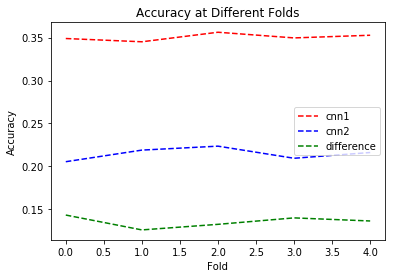

In [84]:
# Graph Accuracy score of two models -> DONE
### TODO: wtf is this x axis? -> limit it to fit the x label;
import matplotlib.pyplot as plt

ax = plt.subplot()
plt.plot(cnn1_score, 'r--', label="cnn1")
plt.plot(cnn2_score, 'b--', label="cnn2")
plt.plot(cnn_diff, 'g--', label="difference")
# ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Fold")

plt.title("Accuracy at Different Folds")
plt.show()

We can see that while the general trend of increase and decrease for both architectures are similar except for the first fold, CNN1 performs much better overall. The difference of accuracy scores are maximized at the very first fold, and minimized at the third.

### Compare performance (10)

Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve.   

## TODO: Actually do a statistical comparison

In [23]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [29]:
# Use MLP -> DONE
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

In [37]:
%%time
%reload_ext memory_profiler
%memit
mlp.fit(X_train, y_train)

peak memory: 332.30 MiB, increment: 0.01 MiB
Wall time: 1min 35s


In [92]:
# TODO : Tweak the graph function to be used with pickled data.
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn2_data is not None:

        # This is larson's        
#         yhat_cnn = np.argmax(cnn2.predict(np.expand_dims(X_test, axis=1)), axis=1)
#         acc_cnn = mt.accuracy_score(y_test,yhat_cnn)

# This is me trying to call the score
# What would be the fold index?
#         acc_cnn = cnn2_data[fold_index]["accuracy"]
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = mlp.predict(X_test)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

In [94]:
# Graph both for comparison in heatmap -> import Larson.copy_pasta() DONE
compare_mlp_cnn(cnn2_data, mlp, X_validation, y_validation)

In [ ]:
# TODO: Compare memory usages (Possible exceptional points) --> Done with %memit

In [ ]:
# TODO: Explain statistical evaluation
# TODO : Add in the evaluated models from pickle and MLP


# TODO: Confidence Intervals
# from scipy.stats import ttest_rel

# print("cnn1 v cnn2:",ttest_rel(cnn1_eval, cnn2_eval))
# print("cnn2 v mlp:",ttest_rel(cnn2_eval, mlp_eval))
# print("cnn1 v mlp:",ttest_rel(cnn1_eval, mlp_eval))

## Exceptional Work

One idea (required for 7000 level students): Use data expansion to train your CNN models. Does this improve generalization performance? 